In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import sys
sys.path.append('../')

import dataset
import models
from utils import iou

input_shape = (448, 448, 3)
seed = 42
label_names = ['apple', 'banana', 'orange']

In [2]:
train_df = dataset.get_dataframe('../fruits_dataset/train')
train_dataset = dataset.load_dataset_from_df(train_df, num_epochs=1, batch_size=1, seed=seed)

23it [00:00, 56.58it/s]/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
240it [00:05, 45.62it/s]


In [3]:
sample = list(train_dataset.as_numpy_iterator())[1]
batch_input = sample[0]
batch_target = sample[1]

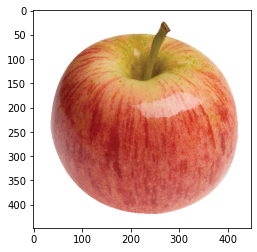

In [4]:
plt.imshow(batch_input[0])

In [5]:
def draw_bboxes_from_tensor_output(img_file, target):
    img = Image.open(img_file)
    bboxes = list()
    labels = list()
    grid_size = target.shape[0]
    
    # Get image width and height
    img_width, img_height = img.width, img.height
    
    # Compute size of each cell in grid
    cell_w, cell_h = img_width / grid_size, img_height / grid_size
    
    # Get bboxes info
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            
            # Check if box contains obj
            if target[i, j, 4] == 1:
                
                # Get x, y, w, h
                x, y, w, h = target[i, j, :4]
                label_dist = target[i, j, 5:]
                label = label_dist.argmax()
                
                # Convert to x_center, y_center, w, h by img original size
                w, h = int(w * img_width), int(h * img_height)
                x_center = int((x + j) * cell_w)
                y_center = int((y + i) * cell_h)
                
                bboxes.append((x_center, y_center, w, h))
                labels.append(label)
    
    draw_bboxes(img_file, bboxes, labels, 'midpoint')
    

def draw_bboxes(img_file, boxes, labels, box_format='midpoint'):
    img = Image.open(img_file)
    img = np.array(img)
    
    if box_format == 'corners':
        for (xmin, ymin, xmax, ymax), label in zip(boxes, labels):
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
            img = cv2.putText(img, label_names[label], (xmin, ymin), 0, 1, (255, 0, 0), 2)
            
    if box_format == 'midpoint':
        for (x, y, w, h) , label in zip(boxes, labels):
            xmin, xmax = int(x - (w / 2)), int(x + (w / 2))
            ymin, ymax = int(y - (h / 2)), int(y + (h / 2))
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
            img = cv2.putText(img, label_names[label], (xmin, ymin), 0, 1, (255, 0, 0), 2)
            
    plt.figure(figsize=(8, 7))
    plt.imshow(img)

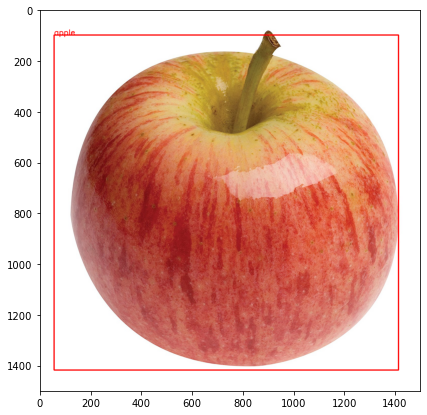

In [6]:
draw_bboxes_from_tensor_output('../fruits_dataset/train/apple_10.jpg', batch_target[0])

In [7]:
batch_target[0, 3, 3]

array([0.42533332, 0.542     , 0.90466666, 0.88      , 1.        ,
       1.        , 0.        , 0.        ], dtype=float32)

In [8]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from models import YoloV1
import dataset
from utils import transform_images, draw_output
import tensorflow as tf

weights_path = '../weight/yolo_best_weights.hdf5'

yolo = YoloV1(input_shape=input_shape, num_classes=len(label_names))
yolo.load_weights(weights_path)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [9]:
batch_output = yolo(batch_input, training=True)

In [10]:
batch_output[0, 3, 3]

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([-0.20573172,  0.35637832,  4.7701826 , -1.8040663 , -0.9422541 ,
       -2.5373154 ,  3.0636582 ,  1.6070864 , -1.8625008 , -0.07714434,
       -1.1416054 , -1.2914437 , -0.5822375 ], dtype=float32)>

In [11]:
from loss import YoloLoss

In [12]:
loss = YoloLoss()

In [13]:
loss(batch_target, batch_output.numpy())

<tf.Tensor: shape=(), dtype=float32, numpy=0.43269846>

In [20]:
x = batch_target[0, 3, 3, :2]
y = batch_output[0, 3, 3, :2]

In [23]:
temp = tf.reduce_sum(tf.square(x - y), -1)

In [24]:
temp

<tf.Tensor: shape=(), dtype=float32, numpy=0.43269846>

In [25]:
print(x)
print(y)

[0.42533332 0.542     ]
tf.Tensor([-0.20573172  0.35637832], shape=(2,), dtype=float32)
